<a href="https://colab.research.google.com/github/RabiyaAkhtar/AgroYeild-Punjab/blob/main/AgroPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# AgroYeild-Punjab: Wheat Yield Prediction in Punjab
# Author: [Dr. Rabiya Akhtar]
# Date: [May 28th, 2025]

"""
Data Sources:
1. Wheat Yield Data: 'production-and-yield-of-wheat-by-districts-punjab.csv'
   - Source: Punjab Agriculture Department
   - Contains: Annual wheat production and yield by district from 2007-2021
   - Format: District, Year, Yield (kg/hectare)

2. Rainfall Data: 'rainfall-at-selected-stations-the-punjab-pakistan-2010-2021.csv'
   - Source: Pakistan Meteorological Department
   - Contains: Monthly rainfall measurements at selected stations
   - Format: Station/District, Year, Monthly rainfall (mm)

3. Temperature Data: 'temperature-at-selected-centre-the-punjab-pakistan-2021.csv'
   - Source: Pakistan Meteorological Department
   - Contains: Daily mean maximum temperatures at selected centers
   - Format: Station/District, Year, Monthly mean max temp (°C)

Methodology:
1. Data Collection: Gather wheat yield, rainfall and temperature data
2. Data Cleaning: Handle missing values, standardize district names
3. Feature Engineering: Create seasonal aggregates and derived features
4. Data Merging: Combine all datasets into a unified dataframe
5. Exploratory Analysis: Visualize relationships between variables
6. Modeling: Train and evaluate machine learning models
7. Prediction: Generate yield predictions with uncertainty estimates
"""

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings


Summary Statistics:
              Year  Yield_kg_per_hectare  Rainfall_mm  Mean_Max_Temp_C  \
count    99.000000             99.000000    99.000000        99.000000   
mean   2015.909091           2684.525253   648.414141        30.868687   
std       3.044201            669.395118   406.605887         3.551994   
min    2011.000000           1231.000000    40.000000        17.900000   
25%    2013.000000           2291.000000   318.500000        29.800000   
50%    2016.000000           2952.000000   577.000000        31.100000   
75%    2019.000000           3150.500000   914.000000        32.050000   
max    2020.000000           3714.000000  1732.000000        47.700000   

       Temp_Rain_Interaction  District_Avg_Yield  Yield_Deviation  \
count              99.000000           99.000000        99.000000   
mean            19351.580808         2633.972222        50.553030   
std             11502.854152          620.678274       236.456183   
min              1908.000000        

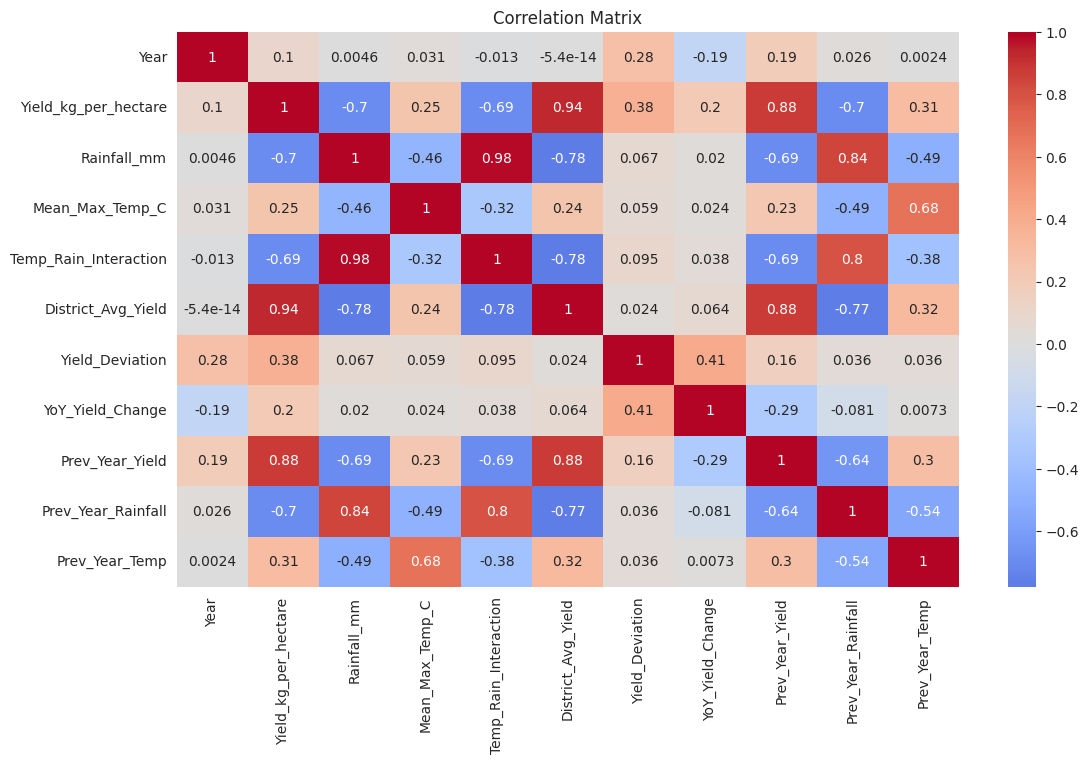

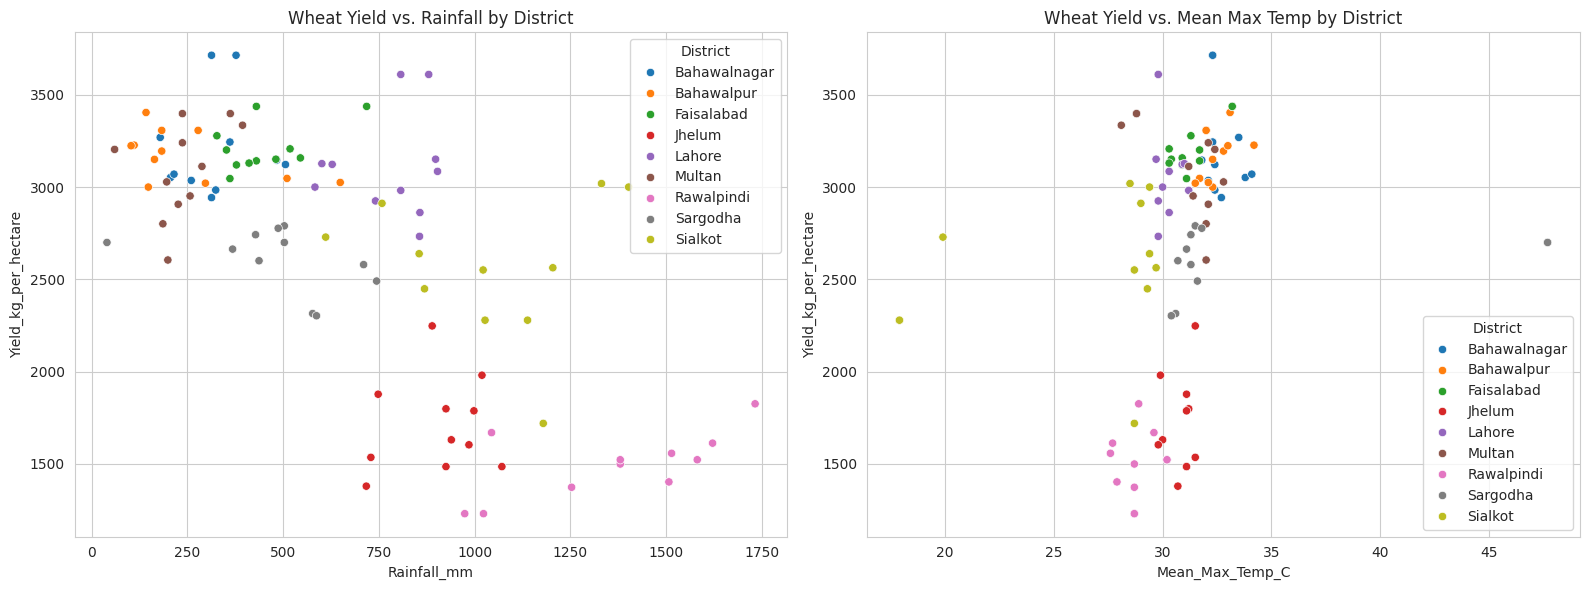

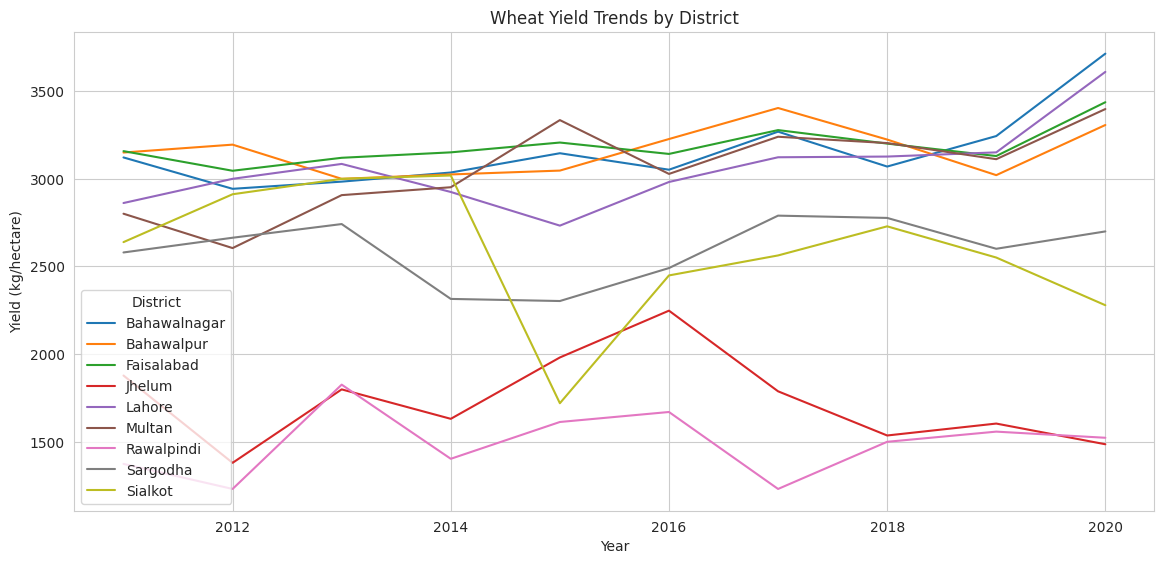


Linear Regression Performance:
MAE: 155.65
R2: 0.92

Random Forest Performance:
MAE: 178.61
R2: 0.90

Gradient Boosting Performance:
MAE: 203.88
R2: 0.86

XGBoost Performance:
MAE: 193.93
R2: 0.86


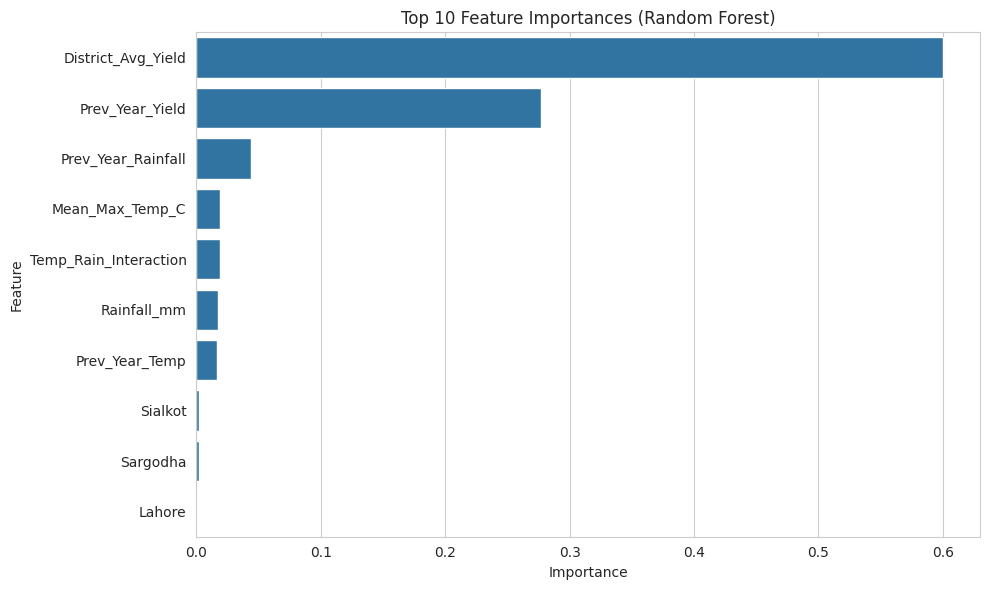


Model training complete! Best model saved as 'wheat_yield_predictor.pkl'
Enhanced dataset saved as 'punjab_agriculture_merged_enhanced.csv'


In [4]:
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

# Load wheat yield data
wheat = pd.read_csv('production-and-yield-of-wheat-by-districts-punjab.csv')

# Clean column names
wheat.columns = wheat.columns.str.strip()
wheat.rename(columns={'Province/division\n/district': 'District'}, inplace=True)

# Remove rows with missing data
wheat.replace('**', np.nan, inplace=True)
wheat.replace('-', np.nan, inplace=True)
wheat.replace('N.A.', np.nan, inplace=True)
wheat.replace('NA', np.nan, inplace=True)

# Convert data to numeric (handling commas in numbers)
for col in wheat.columns[1:]:
    wheat[col] = wheat[col].astype(str).str.replace(',', '').astype(float)

# Reshape from wide to long format for merging
wheat_long = wheat.melt(id_vars='District', var_name='Year', value_name='Yield_kg_per_hectare')
wheat_long['Year'] = wheat_long['Year'].str[:4].astype(int) + 1  # Convert to ending year (e.g., 2007-08 becomes 2008)

# Filter to only years available in other datasets
wheat_long = wheat_long[wheat_long['Year'] >= 2010]

# Load rainfall data
rainfall = pd.read_csv('rainfall-at-selected-stations-the-punjab-pakistan-2010-2021.csv')

# Clean data - remove monthly data at the bottom
rainfall = rainfall[rainfall['Year/  Month'].str.isnumeric()].copy()
rainfall['Year'] = rainfall['Year/  Month'].astype(int)

# Clean column names and handle missing values
rainfall.columns = rainfall.columns.str.strip()
rainfall.replace('NA', np.nan, inplace=True)
rainfall.replace('N.A.', np.nan, inplace=True)
rainfall = rainfall.dropna(how='all', axis=1)

# Convert to numeric
for col in rainfall.columns[1:-1]:  # Skip the first column (Year/ Month) and last column (Year we just added)
    rainfall[col] = pd.to_numeric(rainfall[col], errors='coerce')

# Reshape rainfall data to long format
# First, drop the original 'Year/ Month' column since we have the 'Year' column
rainfall = rainfall.drop('Year/  Month', axis=1)
rainfall_long = rainfall.melt(id_vars='Year', var_name='District', value_name='Rainfall_mm')

# Feature engineering: Calculate seasonal rainfall aggregates
# Assuming months are labeled as Jan, Feb, etc. in columns
if 'Year/  Month' in rainfall.columns:
    # Calculate seasonal aggregates if monthly data is available
    monthly_rainfall = rainfall.copy()
    monthly_rainfall = monthly_rainfall.set_index('Year/  Month').drop('Year', axis=1)

    # Calculate seasonal totals
    seasons = {
        'Winter': ['Dec', 'Jan', 'Feb'],
        'Spring': ['Mar', 'Apr', 'May'],
        'Summer': ['Jun', 'Jul', 'Aug'],
        'Fall': ['Sep', 'Oct', 'Nov']
    }

    seasonal_rainfall = pd.DataFrame()
    for season, months in seasons.items():
        # Check if any of the season months exist in the data
        available_months = [m for m in months if m in monthly_rainfall.columns]
        if available_months:
            seasonal_rainfall[f'Rainfall_{season}_mm'] = monthly_rainfall[available_months].sum(axis=1)

    seasonal_rainfall['Year'] = monthly_rainfall['Year']
    seasonal_rainfall = seasonal_rainfall.reset_index(drop=True)

    # Merge seasonal aggregates back into rainfall_long
    rainfall_long = rainfall_long.merge(seasonal_rainfall, on='Year', how='left')

# Load temperature data
temp = pd.read_csv('temperature-at-selected-centre-the-punjab-pakistan-2021.csv')

# Extract mean maximum temperatures (first section)
temp_data = temp[temp['Year'].str.isnumeric()].copy()
temp_data['Year'] = temp_data['Year'].astype(int)

# Clean column names and handle missing values
temp_data.columns = temp_data.columns.str.strip()
temp_data.replace('NA', np.nan, inplace=True)
temp_data.replace('N.A.', np.nan, inplace=True)

# Convert to numeric
for col in temp_data.columns[1:]:
    temp_data[col] = pd.to_numeric(temp_data[col], errors='coerce')

# Reshape temperature data to long format
temp_long = temp_data.melt(id_vars='Year', var_name='District', value_name='Mean_Max_Temp_C')

# Create mapping for district names to ensure consistency
district_mapping = {
    'Rawalpindi / Islamabad': 'Rawalpindi',
    'Rawalpindi': 'Rawalpindi',
    'T.T.Singh': 'Toba Tek Singh',
    'Mandi Baha-ud-Din': 'Mandi Bahauddin',
    'D.G.Khan': 'Dera Ghazi Khan'
}

# Apply mapping to all datasets
wheat_long['District'] = wheat_long['District'].replace(district_mapping)
rainfall_long['District'] = rainfall_long['District'].replace(district_mapping)
temp_long['District'] = temp_long['District'].replace(district_mapping)

# First merge wheat and rainfall
merged_df = pd.merge(
    wheat_long,
    rainfall_long,
    on=['District', 'Year'],
    how='inner'  # Only keep rows present in both datasets
)

# Convert Rainfall_mm to float
merged_df['Rainfall_mm'] = pd.to_numeric(merged_df['Rainfall_mm'], errors='coerce')

# Then merge with temperature data
merged_df = pd.merge(
    merged_df,
    temp_long,
    on=['District', 'Year'],
    how='left'
)

# Drop rows where yield is missing (our primary variable of interest)
merged_df = merged_df.dropna(subset=['Yield_kg_per_hectare'])

# Handle remaining missing values with district medians
for col in ['Rainfall_mm', 'Mean_Max_Temp_C']:
    merged_df[col] = merged_df.groupby('District')[col].transform(
        lambda x: x.fillna(x.median())
    )

# Feature Engineering: Create derived features
# 1. Temperature-Rainfall interaction term
merged_df['Temp_Rain_Interaction'] = merged_df['Mean_Max_Temp_C'] * merged_df['Rainfall_mm']

# 2. Historical yield averages by district
district_yield_avg = merged_df.groupby('District')['Yield_kg_per_hectare'].mean().reset_index()
district_yield_avg.columns = ['District', 'District_Avg_Yield']
merged_df = merged_df.merge(district_yield_avg, on='District', how='left')

# 3. Yield deviation from district average
merged_df['Yield_Deviation'] = merged_df['Yield_kg_per_hectare'] - merged_df['District_Avg_Yield']

# 4. Year-over-year yield change
merged_df = merged_df.sort_values(['District', 'Year'])
merged_df['YoY_Yield_Change'] = merged_df.groupby('District')['Yield_kg_per_hectare'].diff()

# 5. Lagged features (previous year's yield and weather)
merged_df['Prev_Year_Yield'] = merged_df.groupby('District')['Yield_kg_per_hectare'].shift(1)
merged_df['Prev_Year_Rainfall'] = merged_df.groupby('District')['Rainfall_mm'].shift(1)
merged_df['Prev_Year_Temp'] = merged_df.groupby('District')['Mean_Max_Temp_C'].shift(1)

# Drop rows with missing values created by lagged features
merged_df = merged_df.dropna()

# Exploratory Data Analysis
print("\nSummary Statistics:")
print(merged_df.describe())

# Correlation matrix - select only numeric columns
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
corr_matrix = merged_df[numeric_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout(pad=2.0)
plt.show()

print("\n"*2)


# Plot yield vs. rainfall and temperature
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(wspace=0.4)  # Space between subplots

sns.scatterplot(data=merged_df, x='Rainfall_mm', y='Yield_kg_per_hectare', hue='District', ax=axes[0])
axes[0].set_title('Wheat Yield vs. Rainfall by District')

sns.scatterplot(data=merged_df, x='Mean_Max_Temp_C', y='Yield_kg_per_hectare', hue='District', ax=axes[1])
axes[1].set_title('Wheat Yield vs. Mean Max Temp by District')
plt.tight_layout()
plt.show()


print("\n"*2)

# Time series of yield by district
plt.figure(figsize=(12, 6))
sns.lineplot(data=merged_df, x='Year', y='Yield_kg_per_hectare', hue='District')
plt.title('Wheat Yield Trends by District')
plt.ylabel('Yield (kg/hectare)')
plt.tight_layout(pad=2.0)
plt.show()

# Prepare data for modeling
# Select features and target
features = ['Rainfall_mm', 'Mean_Max_Temp_C', 'Temp_Rain_Interaction',
            'District_Avg_Yield', 'Prev_Year_Yield', 'Prev_Year_Rainfall',
            'Prev_Year_Temp']
target = 'Yield_kg_per_hectare'

X = merged_df[features]
y = merged_df[target]

# Convert district to categorical and one-hot encode
X = pd.get_dummies(merged_df['District']).join(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Model Training and Evaluation
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'R2': r2,
        'model': pipeline
    }

    print(f"\n{name} Performance:")
    print(f"MAE: {mae:.2f}")
    print(f"R2: {r2:.2f}")

# Feature Importance from best model (Random Forest)
best_model = results['Random Forest']['model']
rf_model = best_model.named_steps['model']

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.show()

# Save the best model and merged data
import joblib
joblib.dump(best_model, 'wheat_yield_predictor.pkl')
merged_df.to_csv('punjab_agriculture_merged_enhanced.csv', index=False)

print("\nModel training complete! Best model saved as 'wheat_yield_predictor.pkl'")
print("Enhanced dataset saved as 'punjab_agriculture_merged_enhanced.csv'")